# CNN for MNIST

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms as transforms

# Define device - use GPU if available
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [ ]:
class SmallCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # First convolutional layer: input channels=1 (grayscale), output channels=32
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        # Second convolutional layer: 32 -> 64 channels
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        # Pooling layer to reduce spatial dimensions
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Dropout for regularization
        self.dropout = nn.Dropout(0.25)
        # Fully connected layers: 
        # After two pooling layers, the 28x28 input becomes 7x7 (since 28/2/2 = 7)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)  # 10 output classes for MNIST

        # Activation function
        self.relu = nn.ReLU()

    def forward(self, x):
        # Convolution, activation and pooling steps
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)

        # Flatten the feature maps for the fully connected layers
        x = x.view(x.size(0), -1)

        x = self.dropout(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [9]:
# Hyperparameters
batch_size = 64
learning_rate = 0.001
num_epochs = 10

# Data transformation: converting to tensor and normalizing the images
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Download and load the MNIST dataset
dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Split the dataset into training and validation sets (90% train, 10% val)
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)


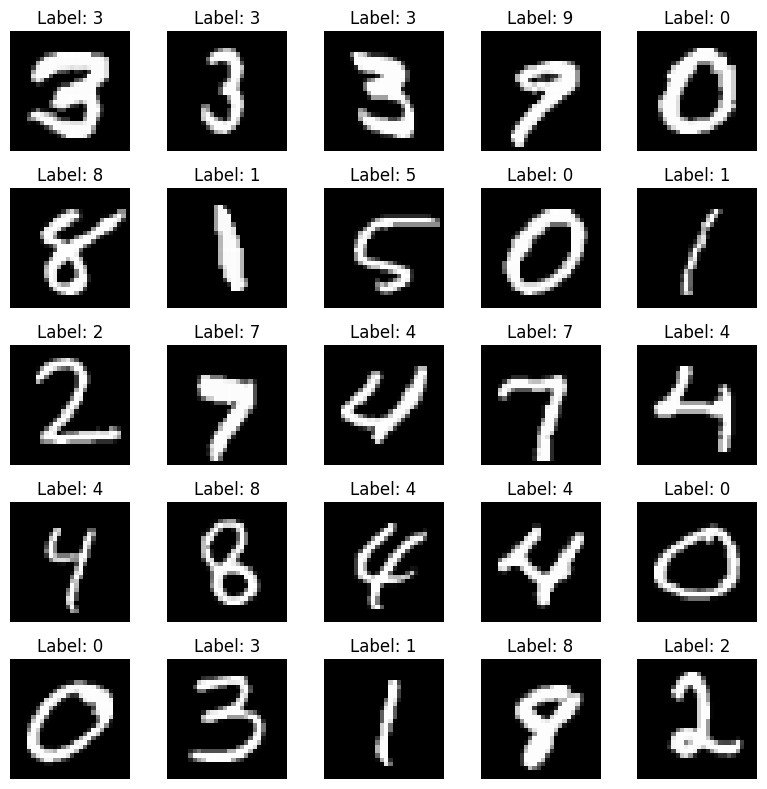

In [10]:
import torch
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

# Define the transformation (same as in your training pipeline)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load the MNIST training dataset
mnist_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Create a grid of images: 5 rows x 5 columns
figure = plt.figure(figsize=(8, 8))
cols, rows = 5, 5

for i in range(1, cols * rows + 1):
    # Randomly sample an image from the dataset
    sample_idx = torch.randint(len(mnist_dataset), size=(1,)).item()
    image, label = mnist_dataset[sample_idx]
    # Remove the channel dimension for display (from [1, 28, 28] to [28, 28])
    image = image.squeeze(0)
    # Since the image is normalized, we can unnormalize it for visualization if needed:
    image = image * 0.3081 + 0.1307

    # Add a subplot for each image
    ax = figure.add_subplot(rows, cols, i)
    ax.set_title(f"Label: {label}")
    ax.axis("off")
    ax.imshow(image, cmap="gray")

plt.tight_layout()
plt.show()


In [11]:
# Initialize the model, loss function, and optimizer
model = SmallCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop with validation evaluation
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    avg_train_loss = running_loss / len(train_loader)
    
    # Evaluate on the validation set
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            # Choose the class with the highest probability
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_accuracy = 100 * correct / total
    
    print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {avg_train_loss:.4f} | Val Accuracy: {val_accuracy:.2f}%")


Epoch [1/10] Train Loss: 0.1785 | Val Accuracy: 98.30%
Epoch [2/10] Train Loss: 0.0642 | Val Accuracy: 98.63%
Epoch [3/10] Train Loss: 0.0483 | Val Accuracy: 98.72%
Epoch [4/10] Train Loss: 0.0410 | Val Accuracy: 98.95%
Epoch [5/10] Train Loss: 0.0317 | Val Accuracy: 99.02%
Epoch [6/10] Train Loss: 0.0280 | Val Accuracy: 99.00%
Epoch [7/10] Train Loss: 0.0249 | Val Accuracy: 99.02%
Epoch [8/10] Train Loss: 0.0242 | Val Accuracy: 98.93%
Epoch [9/10] Train Loss: 0.0209 | Val Accuracy: 99.05%
Epoch [10/10] Train Loss: 0.0176 | Val Accuracy: 98.97%


In [12]:
# Final test set evaluation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 99.14%
